# Chapter 23.4 The Case of Metric Predictors

In [1]:
#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

# numpyro
import jax
import jax.numpy as jnp
from jax import random, vmap
from jax.nn import softmax, softplus
from jax.scipy.special import logsumexp, logit, expit

import numpyro
import numpyro as npr
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS, Predictive

numpyro.set_host_device_count(4)  # 4 chains in MCMC

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import scipy
import scipy.stats as stats
from matplotlib import gridspec
from IPython.display import Image

%matplotlib inline
plt.style.use('seaborn-white')

color = '#87ceeb'

f_dict = {'size':16}

In [2]:
%load_ext watermark
%watermark -p pandas,numpy,matplotlib,seaborn,scipy,arviz,numpyro,jax

pandas    : 1.2.1
numpy     : 1.19.5
matplotlib: 3.3.3
seaborn   : 0.11.1
scipy     : 1.6.0
arviz     : 0.11.2
numpyro   : 0.5.0
jax       : 0.2.8



## Helper Functions

In [3]:
# these helper functions convert numpy array into jax.numpy array
# then after computation, convert back to numpy array
def prior_predictive(model, d):
    Pred = Predictive(model, num_samples=2021)
    jax_data = {k: jnp.array(v) if isinstance(v, np.ndarray) else v for k, v in d.items() }
    samples = Pred(random.PRNGKey(0), **jax_data)
    np_samples = {k: np.array(v) if isinstance(v, jnp.ndarray) else v for k, v in samples.items() }
    return np_samples

def np2jnp(samples):
    jnp_samples = {k: np.array(v) if isinstance(v, np.ndarray) else v for k, v in samples.items() }
    return jnp_samples

def jnp2np(samples):
    np_samples = {k: np.array(v) if isinstance(v, jnp.ndarray) else v for k, v in samples.items() }
    return np_samples

def mcmc_sampling(model, d, num_warmup=500, num_samples=2000, num_chains=4):
    jax_data = {k: jnp.array(v) if isinstance(v, np.ndarray) else v for k, v in d.items() }
    # MCMC
    mcmc_engine = MCMC(NUTS(model), num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)
    mcmc_engine.run(random.PRNGKey(0), **jax_data)
    samples = mcmc_engine.get_samples()
    #
    np_samples = {k: np.array(v) if isinstance(v, jnp.ndarray) else v for k, v in samples.items() }
    mcmc_engine.print_summary()
    return np_samples

In [4]:
def print_shapes(s):
    for k in s.keys():
        print(f'{k:12} ', s[k].shape) 

In [5]:
def plot_npdfs(a, method=None): #='hist'):
    fig, axes = plt.subplots(1, a.shape[1], figsize=(13,2))
    for i, ax in enumerate(axes):
        if method == 'hist':
            ax.hist(a[:,i], bins=20)
        else:
            az.plot_posterior(a[:,i], ax=ax)

In [6]:
def plot_thresholds(thresh_samples):
    thmat = thresh_samples # +1 is necessary to shift to the 1-based world as in DBDA book
    th_mean = np.repeat(thmat.mean(axis=1)[:,np.newaxis], thmat.shape[1], axis=1)
    # the same dimensions: th_mean.shape, thmat.shape

    plt.vlines(x=thmat.mean(axis=0), ymin=th_mean.min(), ymax=th_mean.max(), 
               colors='#DDBBAA', linestyles='dashed', alpha=.4)
    plt.scatter(thmat, th_mean, alpha=.1, s=1);
    plt.xticks(ticks=thmat.mean(axis=0))
    plt.xlabel('thresholds')
    plt.ylabel('Mean Thresholds (per sample)')

## One Predictor 

- $\mu_i = \beta_0 + \beta_1 * X_i$

In [12]:
df3 = pd.read_csv('data/OrdinalProbitData-LinReg-2.csv')
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       200 non-null    float64
 1   Y       200 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 3.2 KB


In [89]:
nYlevels = len(df3.Y.unique())
Y = jnp.array(df3.Y.values)  # python is 0-based, Categorical produces 0-based outcomes
X = jnp.array(df3.X.values)
print(nYlevels, len(Y), len(X))

7 200 200


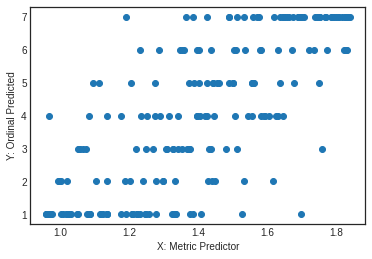

In [90]:
plt.scatter(X, Y); plt.xlabel('X: Metric Predictor'); plt.ylabel('Y: Ordinal Predicted');

In [104]:
Y[:3]

DeviceArray([1, 1, 5], dtype=int32)

## Ordinal Probit, Book's way

In [105]:
def getAmat(nYlevels):
    a = np.eye(nYlevels)
    for j in range(a.shape[0]-1):
        a[j+1,j] = -1 
    return jnp.array(a)

def model_1group_1metric(nYlevels, Amat, X, y=None):
    # preprocessing
    zY = y - 1 if y is not None else None
    Xmean = X.mean()
    Xstd = X.std()
    zX = (X - Xmean) / Xstd
    
    # cutpoints, we need K-1 thresholds
    cuts_init = jnp.array([i+.5 for i in range(nYlevels-1)])
    with npr.plate('cuts_draw_plate', size=nYlevels-1):
        cuts_normal = npr.sample('cuts_normal', dist.Normal(0., 2.)) 
    cuts = cuts_init + cuts_normal
    npr.deterministic('cuts_draw', cuts)
    
    cuts = jax.ops.index_update(cuts, jax.ops.index[0], 0.5)  # cuts[0] = .5 
    cuts = jax.ops.index_update(cuts, jax.ops.index[-1], nYlevels - 1 -.5)  # cuts[-1] = 5.5
    npr.deterministic('cuts', cuts)

    # base normal 
    sigma = npr.sample(f'sigma', dist.Uniform(low=nYlevels/1000, high=nYlevels*10))
    zb0 = npr.sample(f'zb0', dist.Normal((1. + nYlevels) / 2, nYlevels))
    zb  = npr.sample('zb', dist.Normal(0, nYlevels))
    
    # regression, 
    mu = zb0 + zb * zX   # zX[k] --> y[k]   , zb0 + zb * (X - mX)/sX
#     print('mu', mu.shape)
#     print('cuts', cuts.shape)
    
    # probit comp.
    cdfs = jax.scipy.stats.norm.cdf(cuts.reshape(-1,1), loc=mu, scale=sigma) 
#     print('cdfs norm', cdfs.shape)
    
    cdfs = jnp.concatenate((cdfs, jnp.array([[1.]*mu.shape[0]])))  # nYlevels x len(zX)
    npr.deterministic(f'cdfs', cdfs)
#     print('cdfs', cdfs.shape)
    
    diff = jnp.dot(Amat, cdfs)
    npr.deterministic(f'diff', diff)

    max0 = jnp.maximum(0., diff)  # prob = max(0, cdf[i] - cdf[i-1]), see the matrix A
    probs = max0 / max0.sum(axis=0)
    npr.deterministic(f'probs', probs)
#     print(probs[:,0].sum(), probs.shape)
    
    # observation
    yobs = npr.sample(f'obs', dist.Categorical(probs=probs.T), obs=zY)  ## The probability should be transposed.
    
    # transform back
    cuts1 = cuts + 1
    b0    = zb0 - zb*Xmean/Xstd + 1
    b     = zb * Xmean/Xstd
    mu   = mu + 1
    yobs  = yobs + 1
    
    npr.deterministic('cuts1', cuts1)
    npr.deterministic('b0', b0)
    npr.deterministic('b', b)
    npr.deterministic('mu', mu)
    npr.deterministic('yobs', yobs)
#

### Prior Predictive

In [106]:
data_prior = dict(nYlevels=nYlevels, Amat=getAmat(nYlevels), X=X)  # for Prior Predictive

s= prior_predictive(model_1group_1metric, data_prior)

[(f'{k:12} ', s[k].shape) for k in s.keys()]

[('b            ', (2021,)),
 ('b0           ', (2021,)),
 ('cdfs         ', (2021, 7, 200)),
 ('cuts         ', (2021, 6)),
 ('cuts1        ', (2021, 6)),
 ('cuts_draw    ', (2021, 6)),
 ('cuts_normal  ', (2021, 6)),
 ('diff         ', (2021, 7, 200)),
 ('mu           ', (2021, 200)),
 ('obs          ', (2021, 200)),
 ('probs        ', (2021, 7, 200)),
 ('sigma        ', (2021,)),
 ('yobs         ', (2021, 200)),
 ('zb           ', (2021,)),
 ('zb0          ', (2021,))]

In [107]:
s['cuts']

array([[ 0.5       , -0.29584447,  6.278513  ,  4.580793  ,  6.527414  ,
         5.5       ],
       [ 0.5       ,  4.4864955 ,  6.9601407 ,  2.8547158 ,  5.473972  ,
         5.5       ],
       [ 0.5       ,  2.0092144 ,  5.1013036 ,  4.767463  ,  1.8835107 ,
         5.5       ],
       ...,
       [ 0.5       ,  0.6125853 ,  4.4696546 ,  7.47542   ,  8.31034   ,
         5.5       ],
       [ 0.5       ,  1.682351  ,  2.6200068 ,  1.6239243 ,  4.8648934 ,
         5.5       ],
       [ 0.5       ,  1.6763806 ,  1.582471  ,  3.5816813 ,  3.2840674 ,
         5.5       ]], dtype=float32)

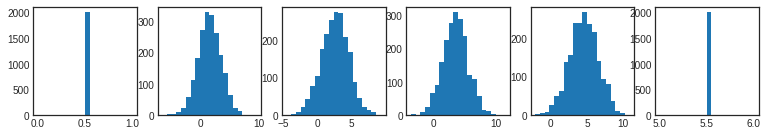

In [108]:
plot_npdfs(s['cuts'], method='hist')

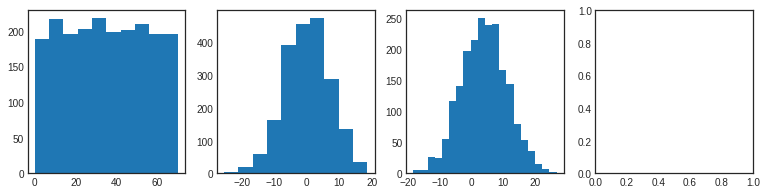

In [109]:
fig, axes = plt.subplots(1,4, figsize=(13,3))
axes[0].hist(s['sigma']);
axes[1].hist(s['zb']);
axes[2].hist(s['zb0'], bins=20);

### MCMC Inference

In [111]:
%%time
data = dict(nYlevels=nYlevels, Amat=getAmat(nYlevels), X=X, y=Y)   # for MCMC

ps = mcmc_sampling(model_1group_1metric, data)


                    mean       std    median      5.0%     95.0%     n_eff     r_hat
cuts_normal[0]     -0.01      1.99     -0.03     -3.12      3.49  12576.01      1.00
cuts_normal[1]     -0.15      0.16     -0.16     -0.42      0.11   4917.42      1.00
cuts_normal[2]     -0.18      0.20     -0.18     -0.52      0.15   4001.80      1.00
cuts_normal[3]     -0.07      0.21     -0.07     -0.43      0.26   4256.96      1.00
cuts_normal[4]     -0.08      0.19     -0.07     -0.36      0.25   5652.96      1.00
cuts_normal[5]     -0.00      2.02      0.01     -3.34      3.27  12020.13      1.00
         sigma      2.15      0.17      2.14      1.88      2.42   8070.92      1.00
            zb      2.42      0.21      2.42      2.08      2.75   8612.49      1.00
           zb0      2.92      0.18      2.92      2.61      3.22   6705.74      1.00

Number of divergences: 0
CPU times: user 11.1 s, sys: 1.43 s, total: 12.5 s
Wall time: 7.69 s


In [112]:
[(f'{k:12} ', ps[k].shape) for k in ps.keys()]

[('b            ', (8000,)),
 ('b0           ', (8000,)),
 ('cdfs         ', (8000, 7, 200)),
 ('cuts         ', (8000, 6)),
 ('cuts1        ', (8000, 6)),
 ('cuts_draw    ', (8000, 6)),
 ('cuts_normal  ', (8000, 6)),
 ('diff         ', (8000, 7, 200)),
 ('mu           ', (8000, 200)),
 ('probs        ', (8000, 7, 200)),
 ('sigma        ', (8000,)),
 ('yobs         ', (8000, 200)),
 ('zb           ', (8000,)),
 ('zb0          ', (8000,))]

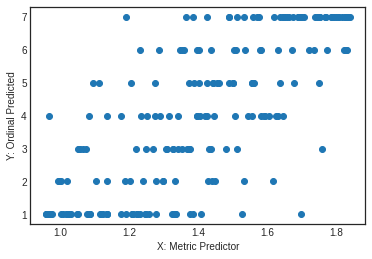

In [113]:
plt.scatter(X, Y); plt.xlabel('X: Metric Predictor'); plt.ylabel('Y: Ordinal Predicted');

In [114]:
x = 1.
mu = ps['b0'] + ps['b']*x

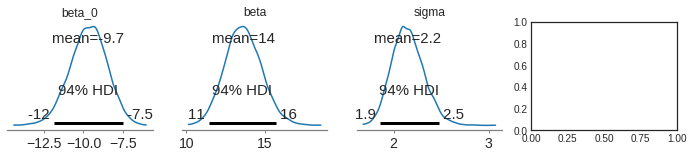

In [115]:
fig, axes = plt.subplots(1, 4, figsize=(12,2))
i=0; ax=axes[i]; az.plot_posterior(ps['b0'], ax=axes[i]); ax.set_title('beta_0');
i=1; ax=axes[i]; az.plot_posterior(ps['b'], ax=axes[i]); ax.set_title('beta');
ax=axes[2]; az.plot_posterior(ps['sigma'], ax=axes[2]); ax.set_title('sigma');

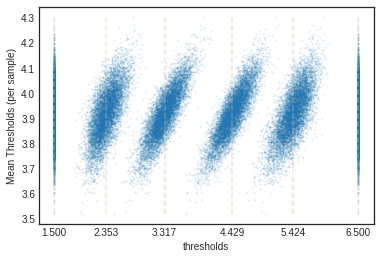

In [116]:
plot_thresholds(ps['cuts1'])  # shift +1 to have DBDA range

In [119]:
X.shape

(200,)

In [120]:
# def posterior_predictive(model, ps):
Xtst = jnp.array([1., 2.])
Pred = Predictive(model_1group_1metric, posterior_samples=np2jnp(ps))
samples = Pred(random.PRNGKey(0), nYlevels, getAmat(nYlevels), Xtst)
np_samples = {k: np.array(v) if isinstance(v, jnp.ndarray) else v for k, v in samples.items() }
print_shapes(np_samples)

b             (8000,)
b0            (8000,)
cdfs          (8000, 7, 2)
cuts          (8000, 6)
cuts1         (8000, 6)
cuts_draw     (8000, 6)
diff          (8000, 7, 2)
mu            (8000, 2)
obs           (8000, 2)
probs         (8000, 7, 2)
yobs          (8000, 2)


In [123]:
a = np_samples
yobs = a['yobs']

(array([ 101.,  153.,  384.,  876., 1184., 1544., 3758.]),
 array([1.        , 1.85714286, 2.71428571, 3.57142857, 4.42857143,
        5.28571429, 6.14285714, 7.        ]),
 <BarContainer object of 7 artists>)

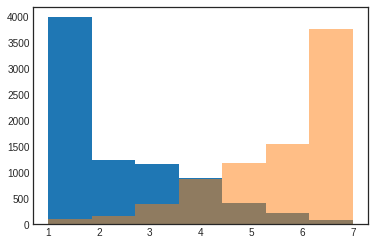

In [127]:
plt.hist(yobs[:,0], bins=7)
plt.hist(yobs[:,1], bins=7, alpha=.5)

**NOTE**

1. DBDA book's categorical values are 1, 2, ...., and the generating density is `Norm(1, 2.5)`
1. The computation here has categorical values 0, 1, ..., therefore the true generating density `Norm(0, 2.5)`
1. The estimated posterior densities from the two models are almost similar to the true density.
1. Likewise, the cutpoint locations have values one less than those in DBDA book.

End.